In [8]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
class DataProvider(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.data = 100
        self.wealth = 0

    def step(self):
        # Provider-specific behavior (e.g., generate data or update state)
        pass

class DataConsumer(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.data = 0
        self.wealth = int(self.random.normalvariate(100, 20))
        self.wealth = max(0, self.wealth)
        self.utility = int(self.random.normalvariate(80, 15))
        self.utility = max(0, self.utility)
        self.has_ever_held_token = False

    def consume_data(self):
        """Consumes data from a random provider."""
        if self.wealth > 0:
            if not self.has_ever_held_token:
                if not self.model.providers:
                    return
                provider = self.random.choice(self.model.providers)
                if provider.data > 0:
                    if self.wealth >= self.model.price:
                        if self.utility > self.model.price:
                            provider.data -= 1
                            self.data += 1
                            self.wealth -= self.model.price
                            provider.wealth += self.model.price
                            self.has_ever_held_token = True
                            print(f"Consumer {self.unique_id} consumed data from Provider and {self.model.providers[0].data} left.")
        else:
            return

class DataMarket(Model):
    """
    A simple data market model using Mesa's AgentSet API.

    References:
        Mesa Overview: https://mesa.readthedocs.io/latest/overview.html
    """
    def __init__(self, num_providers, num_consumers, price, seed=None):
        super().__init__(seed=seed)
        self.num_providers = num_providers
        self.num_consumers = num_consumers
        self.price = price

        self.providers = DataProvider.create_agents(model=self, n=self.num_providers)
        self.consumers = DataConsumer.create_agents(model=self, n=self.num_consumers)

        self.datacollector = DataCollector(
            model_reporters={
                "RemainingData": lambda m: sum([p.data for p in m.providers]),
                "ProviderWealth": lambda m: sum([p.wealth for p in m.providers]),
                "ExperiencedConsumers": lambda m: sum([1 for c in m.consumers if c.has_ever_held_token]),
            }
        )

    def step(self):
        """Advance the model by one step."""
        self.consumers.shuffle_do("consume_data")
        self.datacollector.collect(self)

In [38]:
# Run the simulation
model = DataMarket(num_providers=1, num_consumers=100, price=80, seed=42)
for i in range(100):
    model.step()

# Get the collected data
model_data = model.datacollector.get_model_vars_dataframe()

Consumer 83 consumed data from Provider and 99 left.
Consumer 62 consumed data from Provider and 98 left.
Consumer 6 consumed data from Provider and 97 left.
Consumer 9 consumed data from Provider and 96 left.
Consumer 4 consumed data from Provider and 95 left.
Consumer 67 consumed data from Provider and 94 left.
Consumer 16 consumed data from Provider and 93 left.
Consumer 59 consumed data from Provider and 92 left.
Consumer 32 consumed data from Provider and 91 left.
Consumer 95 consumed data from Provider and 90 left.
Consumer 98 consumed data from Provider and 89 left.
Consumer 14 consumed data from Provider and 88 left.
Consumer 100 consumed data from Provider and 87 left.
Consumer 54 consumed data from Provider and 86 left.
Consumer 75 consumed data from Provider and 85 left.
Consumer 81 consumed data from Provider and 84 left.
Consumer 52 consumed data from Provider and 83 left.
Consumer 38 consumed data from Provider and 82 left.
Consumer 50 consumed data from Provider and 81 l

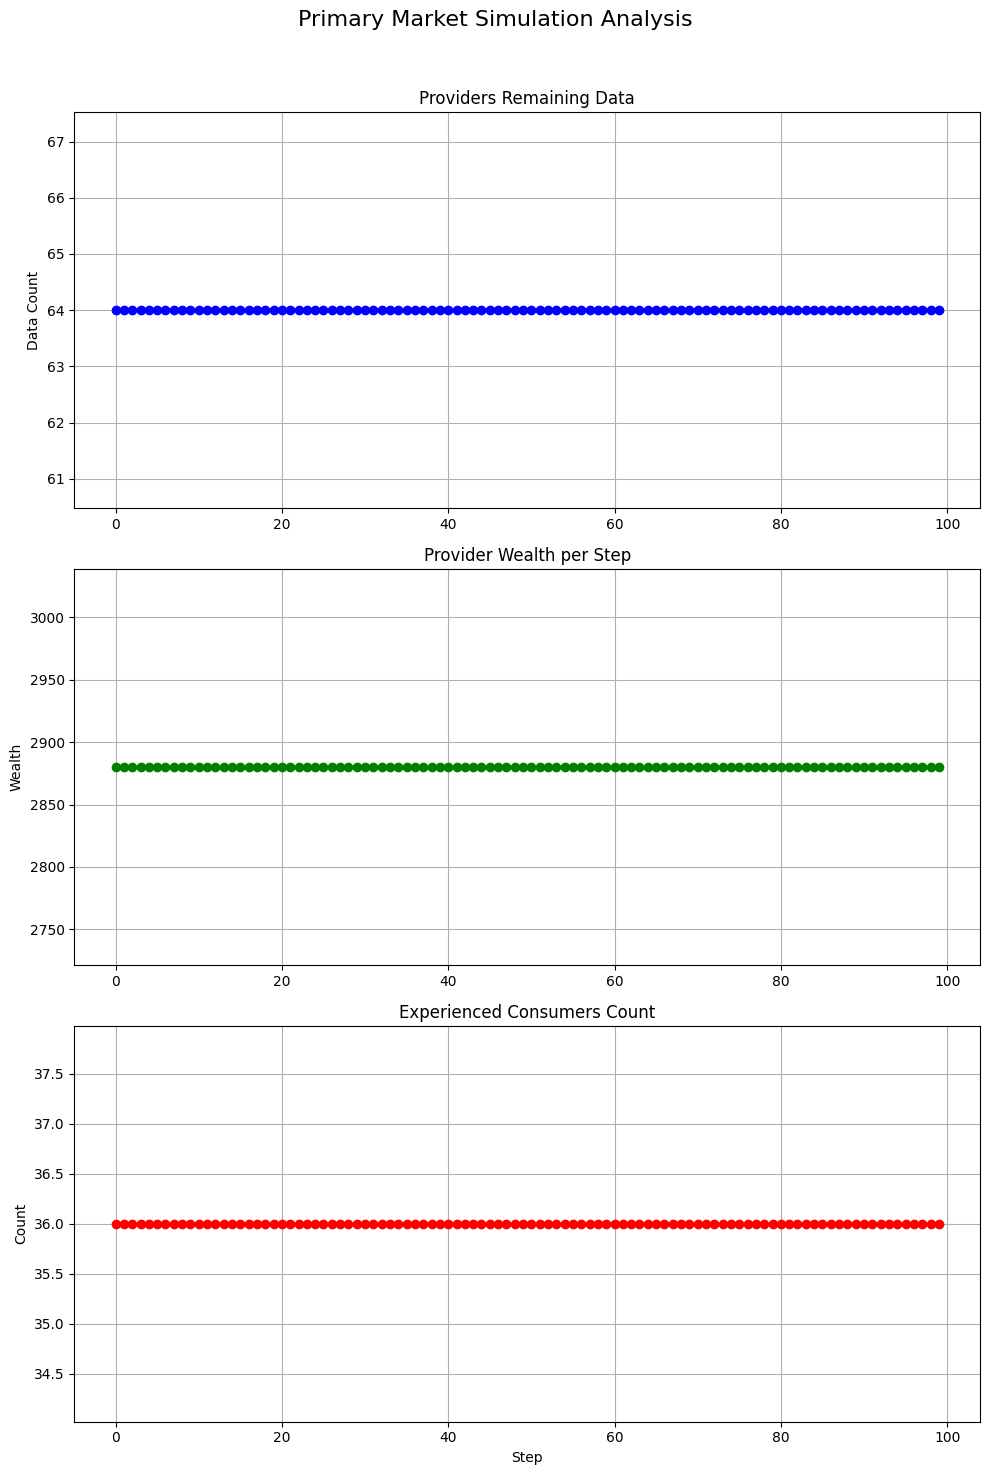

In [39]:
# --- グラフの描画 ---
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Primary Market Simulation Analysis', fontsize=16)

# 1. Providerの残りデータ数
model_data['RemainingData'].plot(ax=axes[0], title='Providers Remaining Data', grid=True, marker='o', color='blue')
axes[0].set_ylabel('Data Count')

# 2. Providerの資産
model_data['ProviderWealth'].plot(ax=axes[1], title='Provider Wealth per Step', grid=True, marker='o', color='green')
axes[1].set_ylabel('Wealth')

# 3. データ保有経験者数
model_data['ExperiencedConsumers'].plot(ax=axes[2], title='Experienced Consumers Count', grid=True, marker='o', color='red')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Step')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()